In [2]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_histories, pred_and_plot, create_confusion_matrix, load_and_prep_image

In [1]:
# Check whether using a GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8f692830-e4c0-ad08-1859-5e470eff4b15)


In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is target dataset in the list of TFDS datasets?

True


In [4]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data,label),
                                             with_info=True) # to also load ds_info


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.I7XRBS_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.I7XRBS_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class Names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?


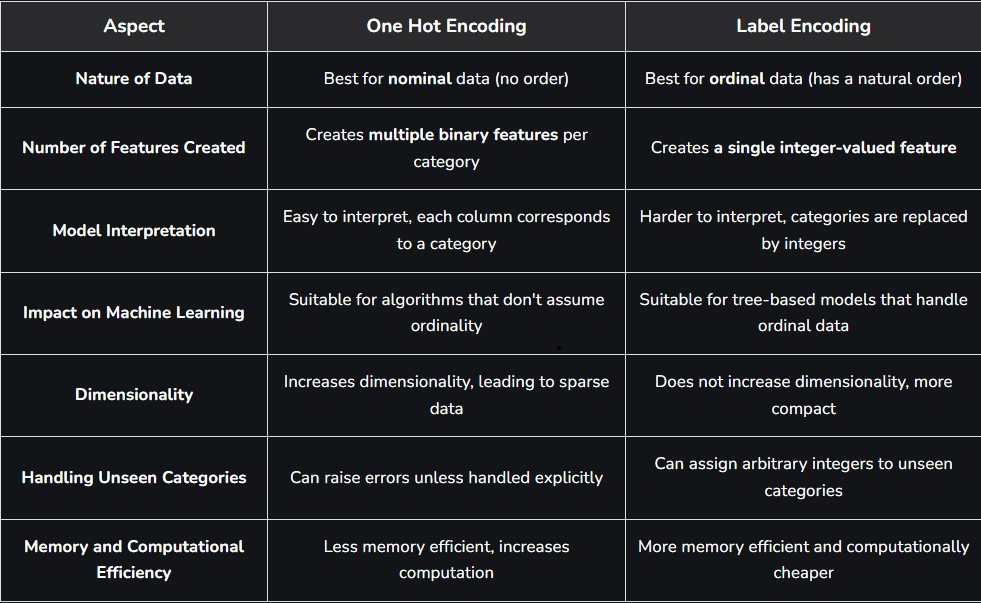

In [ ]:
from IPython.display import Image

Image(filename="Extra Photos/one_hot_vs_label.jpg")

In [5]:
# Feature of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
#Get the class names
class_names = ds_info.features["label"].names # in TFDS instead of "class_names", it has "names"
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [7]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [8]:
# What does one sample of our training data look line?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image Shape : {image.shape}
    Image Datatype : {image.dtype}
    Target Class from Food101 (tensor form) : {label}
    Class Name (str form) : {class_names[label.numpy()]}
    """)


    Image Shape : (512, 512, 3)
    Image Datatype : <dtype: 'uint8'>
    Target Class from Food101 (tensor form) : 18
    Class Name (str form) : chicken_curry
    


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[131,  86,  55],
        [134,  89,  58],
        [137,  92,  61],
        ...,
        [131,  44,   0],
        [135,  49,   2],
        [138,  52,   5]],

       [[134,  89,  58],
        [135,  90,  59],
        [135,  90,  59],
        ...,
        [133,  46,   1],
        [134,  48,   1],
        [134,  48,   1]],

       [[136,  91,  60],
        [137,  92,  61],
        [139,  94,  63],
        ...,
        [137,  53,   7],
        [135,  51,   5],
        [131,  47,   1]],

       ...,

       [[130,  23,   3],
        [134,  31,  14],
        [132,  36,  24],
        ...,
        [243, 248, 242],
        [243, 248, 242],
        [243, 248, 242]],

       [[128,  22,   0],
        [129,  26,   7],
        [124,  28,  14],
        ...,
        [243, 248, 241],
        [242, 247, 240],
        [242, 247, 240]],

       [[132,  26,   2],
        [133,  31,   9],
        [126,  29,  13],
        ...,
        [242, 247, 24

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

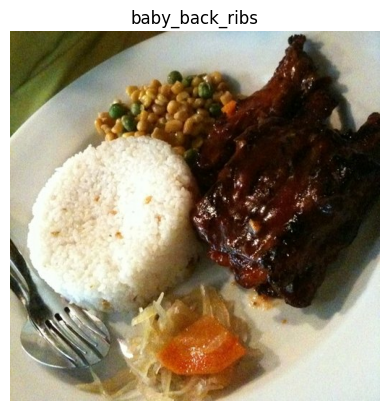

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)


## Create preprocessing functions for our data

Neural networks perform best when data is preprocessed (e.g. batched, normalized, etc.)

However, not all data (including data from TFDS, Kaggle) comes like this.

So in order to get it ready for a NN, you'll often have to write preprocessing funcs. and mat it to your data

## What we know about our data:

* in *'uint-8'* datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are bw. 0 & 255)

## What we know models like:

* Data in *'float32'* datatype (or for mixed precision *'float16'* and *'float32'*
* For batches, all of the tensors within a batch to be of the same size.
* **Scaled/Normalized** (the pixel values are bw. 0 & 1)

In [13]:
# Make a function for preprocessing images
import tensorflow as tf

def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' to 'float32' and reshapes
    image to [img_shape, img_shape, color_channels].

    Args:
        image (tf.Tensor): Input image as a TensorFlow tensor.
        label (Any): Corresponding label for the image.
        img_shape (int, optional): Target size for image resizing (default is 224).

    Returns:
        tuple: A tuple containing the preprocessed image tensor and its label.
    """

    # Reshape the image
    image = tf.image.resize(images=image, size=[img_shape, img_shape])

    # Convert image dtype
    image = tf.image.convert_image_dtype(image=image, dtype="float32")

    return (image, label)

In [14]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image=image, label=label)[0]
print(f"Image before preprocessing :\nDatatype : {image.dtype}\nShape : {image.shape}\n ")
print(f"Image after preprocessing :\nDatatype : {preprocessed_img.dtype}\nShape : {preprocessed_img.shape}\n ")

Image before preprocessing :
Datatype : <dtype: 'uint8'>
Shape : (512, 512, 3)
 
Image after preprocessing :
Datatype : <dtype: 'float32'>
Shape : (224, 224, 3)
 


# Batch & prepare datasets

In [15]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
# normally we'd want len(train_data) for b_s of the shuffle however it's extremely large

# Map preprocessing function to test data
test_data =  test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

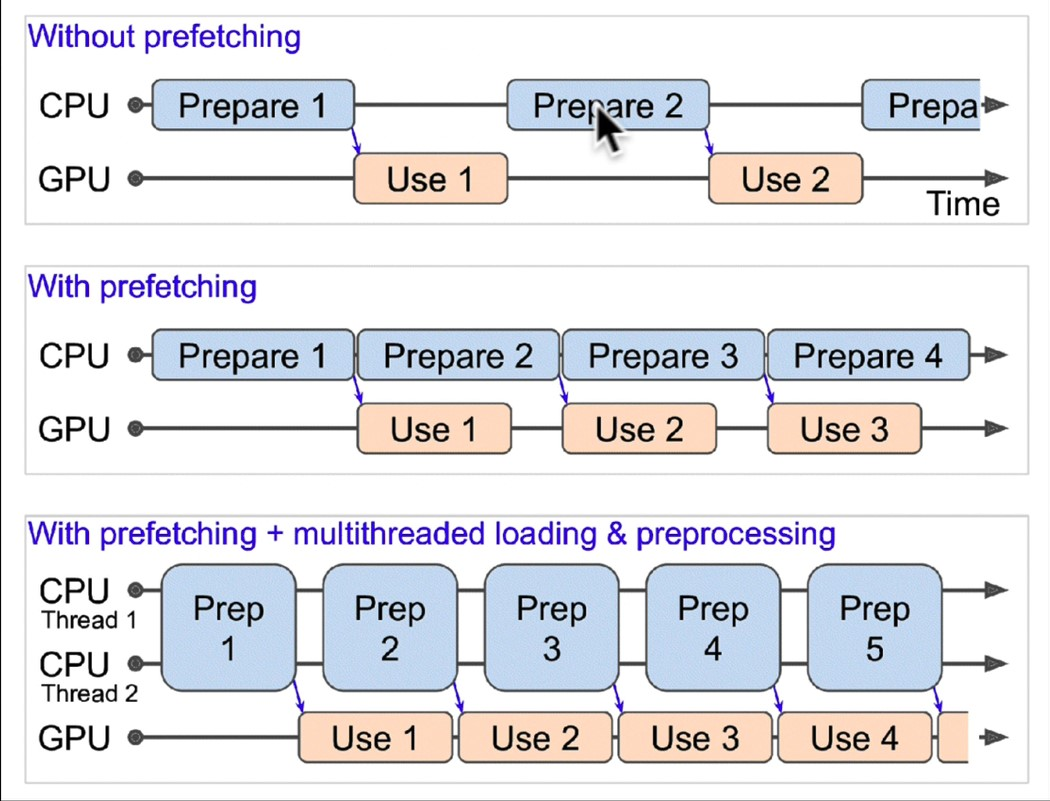

In [ ]:
Image(filename="Extra Photos/prefetch.jpg")

## Extra Material:

* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)
* [Load CSV Data](https://www.tensorflow.org/tutorials/load_data/csv)

# Quick Reminder: What are Callbacks?

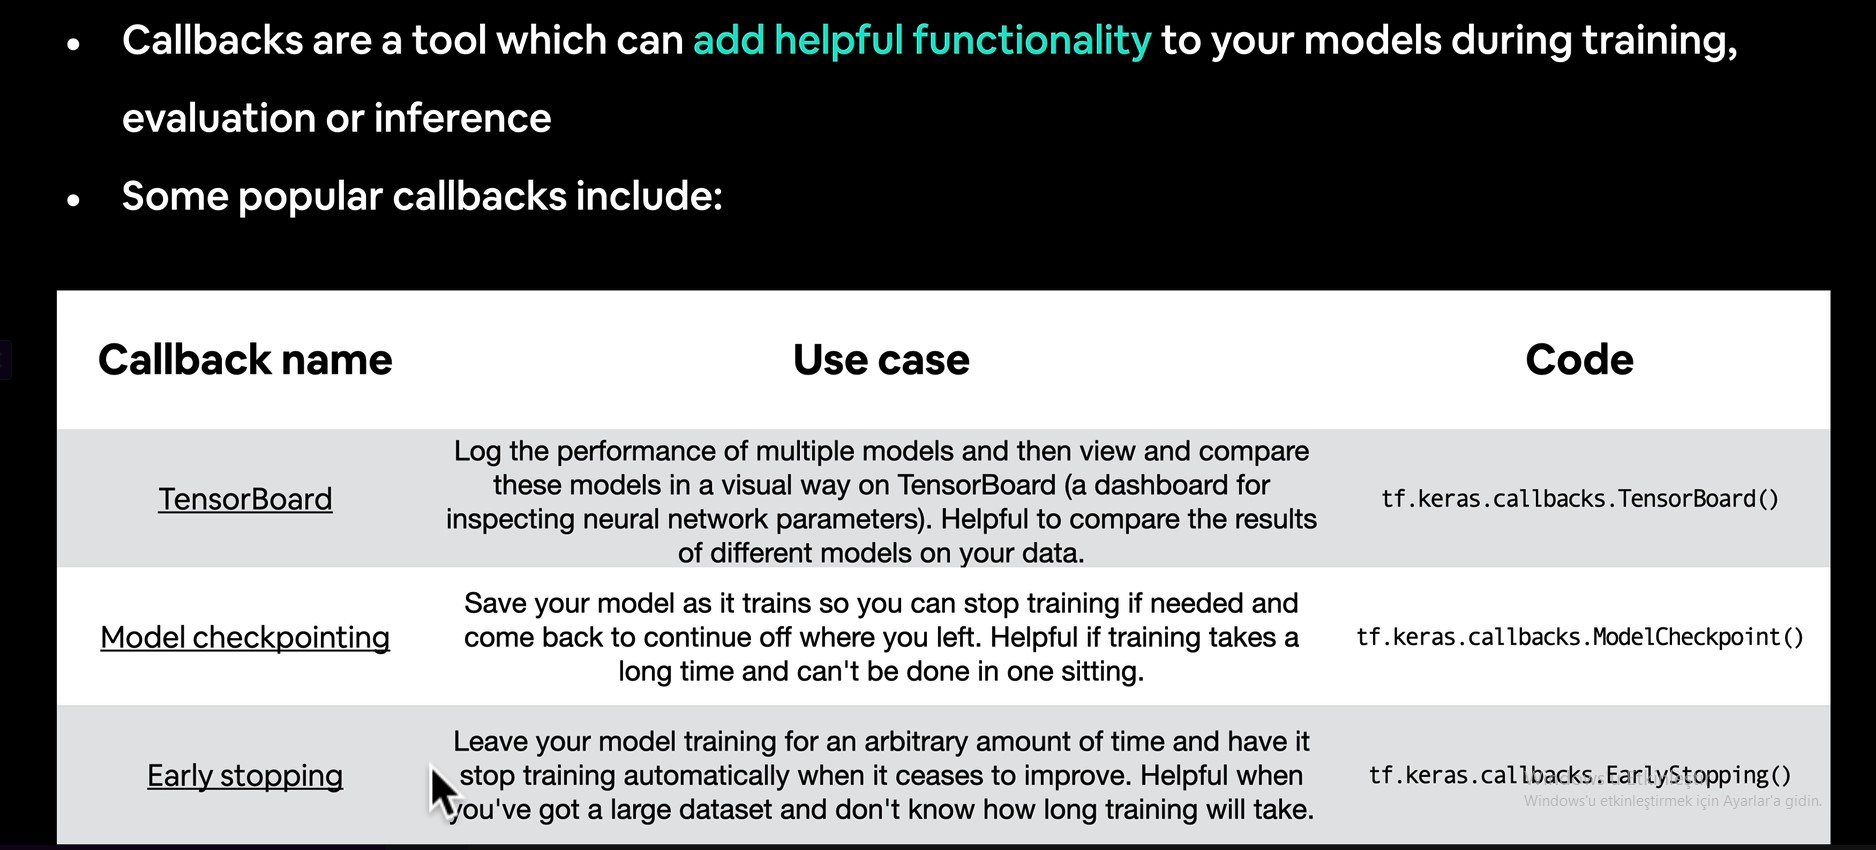

In [ ]:
Image(filename="Extra Photos/callbacks.jpg")

## Create modelling callbacks:

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results.
* ModelCheckpoint callback to save our model's progress after feature extraction.

In [16]:
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "/model_checkpoints/model_checkpoint_p1-fv.weights.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                      monitor="val_acc",
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=0)

# Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 data types to speed up models performance

In [17]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

The error happens when you turn on mixed precision training for EfficientNetBX models.

It'll look something like this:

TypeError: Input 'y' of 'Sub' Op has type float16 that does not match type float32 of argument 'x'

In [20]:
# Build feature extraction model
from tensorflow.keras import layers

# Create base model
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, # We'll have different number of output classes.
                                                   weights='imagenet')
base_model.trainable = False

# Create functional model

# Create input layer
INPUT_SHAPE=(224,224,3)
img_inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")

# Pass our images to our base model (put base model in inference mode)
x = base_model(img_inputs, training=False)

# Create feature vector
x = layers.GlobalAvgPool2D(name="global_average_pooling_2D") (x)

# Create fully connected output layer for our 101 classes.
x = layers.Dense(len(class_names)) (x)

# Determine output layers activation function.
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32") (x) # dtype=tf.float32 is crucial when using mixed-precision training

# Create our Functional API Model
model = tf.keras.Model(img_inputs, outputs)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # since our data is label encoded (i.e labels are in integer form)
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Check the dtype_policy attributes of layers in our model
for layer_number, layer in enumerate(model.layers):
    print(layer_number, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


0 input_layer True float32 <DTypePolicy "mixed_float16">
1 efficientnetv2-b0 False float32 <DTypePolicy "mixed_float16">
2 global_average_pooling_2D True float32 <DTypePolicy "mixed_float16">
3 dense True float32 <DTypePolicy "mixed_float16">
4 softmax_float32 True float32 <DTypePolicy "float32">


## Going through above we see:
* **layer.name** : The human readable name of that particular layer
* **layer.trainable** : Whether that layer is trainable or not
* **layer.dtype** : The data type a layer stores its variables in
* **layer.dtpye_policy** : The data type policy a layer computes on its variables with

In [23]:
# Fit the model
INITIAL_EPOCHS = 3
history_101_food_classes_feature_extract = model.fit(train_data,
          epochs=INITIAL_EPOCHS,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.15 * len(test_data)),
          callbacks=[model_checkpoint_callback,
                     create_tensorboard_callback(dir_name="training_logs",
                                                 experiment_name="efficientnetb0v2_101_classes_all_data_feature_extract")
                     ])

Saving TensorBoard log files to: training_logs/efficientnetb0v2_101_classes_all_data_feature_extract/20250315-062633
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 250s 88ms/step - accuracy: 0.4592 - loss: 2.3630 - val_accuracy: 0.6999 - val_loss: 1.1675
Epoch 2/3


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 186s 65ms/step - accuracy: 0.6546 - loss: 1.3413 - val_accuracy: 0.7217 - val_loss: 1.0467
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 198s 64ms/step - accuracy: 0.6884 - loss: 1.1926 - val_accuracy: 0.7309 - val_loss: 1.0008


## Save the model and upload it to check if it works

In [24]:
# Evaluate on the whole test data
results_feature_extract_model = model.evaluate(test_data)
print(results_feature_extract_model)

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 65ms/step - accuracy: 0.7296 - loss: 1.0069
[1.0045255422592163, 0.7287920713424683]


In [34]:
# Save the current model locally
model.save("/efficientnetb0v2_101_classes_feature_extract_model.keras")

In [37]:
# Load model previously saved above
loaded_model = tf.keras.models.load_model("/efficientnetb0v2_101_classes_feature_extract_model.keras")

In [38]:
# Check loaded models performance (this should be the same as results_feature_extract_model)
import numpy as np

results_loaded_model = loaded_model.evaluate(test_data)
np.isclose(results_feature_extract_model, results_loaded_model)

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - accuracy: 0.7288 - loss: 1.0085


array([ True,  True])

##  Prepare our model for fine-tuning

In [39]:
# Set all of the layers in our model to be trainable (so they're unfrozen)
for layer in loaded_model.layers:
    layer.trainable = True

In [40]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs

fine_tune_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3,
                                                  verbose=1)

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
checkpoint_path = "model_checkpoints/model_checkpoint_p1_-fv_fine_tune.weights.h5"
fine_tune_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                                monitor="val_loss",
                                                                save_best_only=True,
                                                                save_weights_only=True)


In [41]:
# Compile the model for fine-tuning
loaded_model.compile(loss="sparse_categorical_crossentropy", # Since we use label encoded data
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Lowering the learning rate by 10x
                     metrics=["accuracy"])

In [42]:
# Start to fine tune the model
INITIAL_FINE_TUNE_EPOCHS = 100
fine_tune_history = loaded_model.fit(train_data,
                                     epochs=INITIAL_FINE_TUNE_EPOCHS,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps=int(0.15 * len(test_data)),
                                     callbacks=[fine_tune_model_checkpoint,
                                                fine_tune_early_stopping,
                                                create_tensorboard_callback(dir_name="training_logs",
                                                experiment_name="efficientnetb0v2_101_classes_all_data_fine_tune")])


Saving TensorBoard log files to: training_logs/efficientnetb0v2_101_classes_all_data_fine_tune/20250315-064636
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 370s 109ms/step - accuracy: 0.6408 - loss: 1.4133 - val_accuracy: 0.8096 - val_loss: 0.6929
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 197s 82ms/step - accuracy: 0.8020 - loss: 0.7330 - val_accuracy: 0.8300 - val_loss: 0.6084
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 82ms/step - accuracy: 0.8648 - loss: 0.5088 - val_accuracy: 0.8416 - val_loss: 0.5876
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 195s 81ms/step - accuracy: 0.9061 - loss: 0.3557 - val_accuracy: 0.8445 - val_loss: 0.5876
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - accuracy: 0.9358 - loss: 0.2472 - val_accuracy: 0.8422 - val_loss: 0.6019
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 197s 81ms/step - accuracy: 0.9533 - loss: 0.1829 - val_accuracy: 0.8427 - val_loss: 0.6251
Epoch 7/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 193s 80ms/step - accuracy: 0.9646 - loss:

In [43]:
# Evaluate the fine-tuned model
results_fine_tuned_model = loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.8372 - loss: 0.6425


In [2]:
# Let's visualize some of the images the model is making predictions on
import random
import os

test_dir = "/root/tensorflow_datasets/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101/images/"

# Choose a random image from a random class in the dataset
class_name = random.choice(class_names) + "/"
filename = random.choice(os.listdir(test_dir + class_name))
filepath = test_dir + class_name + filename


# Predict on the random image and plot it
pred_and_plot(model=loaded_model, filename=filepath, class_names=class_names)

NameError: name 'class_names' is not defined

In [1]:
import numpy as np

# Get the predicted labels and the true labels
y_labels = []
y_preds = []
pred_probs = []

for image, label in test_data.unbatch().as_numpy_iterator():
    y_labels.append(label)  # Append true label

    # Expand dimensions to make it a batch of 1
    image_batch = np.expand_dims(image, axis=0)

    # Get prediction probabilities
    probs = loaded_model.predict(image_batch, verbose=0)  # Now it has the correct shape
    pred_probs.append(probs)

    # Get predicted class index
    y_preds.append(np.argmax(probs, axis=1)[0])  # Extract integer class

# Now, create confusion matrix
create_confusion_matrix(y_true=y_labels,
                        y_pred=y_preds,
                        classes=class_names,
                        figsize=(100, 100),
                        text_size=20,
                        savefig=True)


NameError: name 'test_data' is not defined

In [ ]:
# Find our models evaluation metrics(precision, recall, f1-score)
from sklearn.metrics import classification_report

report_dict = classification_report(y_true=y_labels, y_pred=y_preds, output_dict=True)

# Get rid of the support metric
for k,v in report_dict.items():
    if (k=="accuracy"):
        break

    report_dict[k].pop("support")

In [ ]:
# Turn evaluation metrics into a DataFrame
import pandas as pd

eval_metrics_df = pd.DataFrame({"class_name" : y_preds,
                         "Precision" : list(report_dict["precision"]),
                         "Recall" : list(report_dict["recall"]),
                         "F1-score" : list(report_dict["f1-score"])})


In [ ]:
def plot_helper(ax, dataframe, metric, color):

    # Plot horizontal bars with the metric
    ax.barh(range(len(metric)), dataframe[metric].values, color=color) # Get the metric values

    # Set y-ticks to be the class names and labels
    ax.set_yticks(range(len(metric)))
    ax.set_yticklabels(metric["class_names"])

    # Set label and title
    ax.set_xlabel(metric)
    ax.set_title(metric + " for 101 Different Food Classes (predicted by FoodVision model)")

    # Invert y-axis (to have the highest score at the top)
    ax.invert_yaxis()

    # Add text annotations to each bar
    for i, score in enumerate(dataframe[metric].values):
        ax.text(0.98 * score, i, f"{score:.2f}", va='center', ha='right', color='black', fontsize=12)

In [ ]:
# Visualize the evaluation metrics
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1, figsize=(12,75)) # 3 rows 1 column

# Plot precision
eval_metrics_df.sort_values("Precision", ascending=False)
plot_helper(axes[0], eval_metrics_df, "Precision", "lightblue")

# Plot recall
eval_metrics_df.sort_values("Recall", ascending=False)
plot_helper(axes[1], eval_metrics_df, "Recall", "lightgreen")

# Plot F1-score
eval_metrics_df.sort_values("F1-score", ascending=False)
plot_helper(axes[2], eval_metrics_df, "F1-score", "red")

plt.tight_layout()
plt.show()

## Find our models most wrong predictions

In [ ]:
# Create a dataframe with all of the predictions.

pred_df = pd.DataFrame({"y_true" : y_labels,
                        "y_pred" : y_preds,
                        "pred_conf" : pred_probs,
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in y_preds]
                       })

In [ ]:
# Find out all wrong predictions in our DataFrame
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

In [ ]:
# Sort our DataFrame to have most wrong predictions on top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]

In [ ]:
# Show on which classes our model is most wrong
print(top_100_wrong)